# Импорты

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from collections import defaultdict

# Класс задач

In [26]:
class Task:
    def __init__(self, name, depends_on, duration, stages):
        self._name       = name
        self._depends_on = depends_on
        self._duration   = duration
        self._stages     = stages 

    @property
    def get_name(self):
        return self._name

    @property
    def get_depends_on(self):
        return self._depends_on.copy()

    @property
    def get_duration(self):
        return self._duration
    
    @property
    def get_stages(self):
        return self._stages

# Работы и их зависимости (по варианту)

In [27]:
# dependencies = [
#     Task('b1',  [],                 9,  (0, 1)),
#     Task('b2',  [],                 7,  (0, 2)),
#     Task('b3',  [],                 13, (0, 3)),
#     Task('b4',  ['b1'],             8,  (1, 4)),
#     Task('b5',  ['b2'],             6,  (2, 4)),
#     Task('b6',  ['b2'],             10, (2, 5)),
#     Task('b7',  ['b3'],             9,  (3, 5)),
#     Task('b8',  ['b4', 'b5'],       13, (4, 5)),
#     Task('b9',  ['b6', 'b7'],       9,  (5, 6)),
#     Task('b10', ['b6', 'b7', 'b8'], 11, (5, 7)),
#     Task('b11', ['b9'],             9,  (6, 7))
# ]

dependencies = [
    Task('b1',  [],                 8,  (0, 1)),
    Task('b2',  [],                 6,  (0, 3)),
    Task('b3',  ['b1'],             13, (1, 6)),
    Task('b4',  ['b1'],             4,  (1, 2)),
    Task('b5',  ['b4'],             5,  (2, 5)),
    Task('b6',  ['b2'],             10, (3, 5)),
    Task('b7',  ['b2'],             6,  (3, 4)),
    Task('b8',  ['b7'],             9,  (4, 5)),
    Task('b9',  ['b5', 'b6', 'b8'], 10, (5, 6)),
    Task('b10', ['b3', 'b4', 'b9'], 7,  (6, 7)),
    Task('b11', ['b5', 'b6', 'b8'], 11, (5, 7))
]

# Методы

## Метод расчета ранних сроков (Tр) для каждого события

In [28]:
def calculate_early_times(graph):
    # Топологическая сортировка узлов
    topo_order = list(nx.topological_sort(graph))

    # Инициализация словаря для хранения Tр
    early_times = {node: 0 for node in graph.nodes}

    # Проход по узлам в топологическом порядке
    for node in topo_order:
        # Все входящие ребра для текущего узла
        predecessors = list(graph.predecessors(node))

        # Если есть предшественники
        if predecessors:
            # Вычисляем максимальное значение (Tр предшественника + длительность работы)
            max_time = max(
                early_times[p] + graph.edges[p, node]['duration']
                for p in predecessors
            )
            early_times[node] = max_time

    return early_times

## Метод расчета поздних сроков (Tп) для каждого события

In [29]:
def calculate_late_times_correct(graph, early_times):
    # Инициализация словаря для хранения Tп
    late_times = {node: 0 for node in graph.nodes}

    # Установка Tп для завершающего узла равным его раннему сроку
    end_node = max(graph.nodes)
    late_times[end_node] = early_times[end_node]

    # Топологическая сортировка узлов в обратном порядке
    topo_order = list(reversed(list(nx.topological_sort(graph))))

    # Проход по узлам в обратном топологическом порядке
    for node in topo_order:
        # Пропускаем завершающий узел, он уже обработан
        if node == end_node:
            continue

        # Все исходящие ребра для текущего узла
        successors = list(graph.successors(node))

        # Если есть последующие узлы, вычисляем минимальное значение
        if successors:
            min_time = min(
                late_times[s] - graph.edges[node, s]['duration']
                for s in successors
            )
            late_times[node] = min_time
        # Если нет последующих узлов (кроме завершающего), присваиваем Tп завершающего узла
        else:
            late_times[node] = late_times[end_node]

    return late_times

## Метод нахождения критического пути

In [30]:
def find_critical_path(critical_works):
    critical_path_edges = list(critical_works)
    
    # Проверяем, что критический путь существует
    if not critical_path_edges:
        return []

    # Создаем список узлов, входящих в критический путь
    critical_path_nodes = set()
    for edge in critical_path_edges:
        critical_path_nodes.add(edge[0])
        critical_path_nodes.add(edge[1])
    
    # Начинаем с начального узла (0) и ищем следующий узел в критическом пути
    start_node = 0
    ordered_path = [start_node]
    
    while True:
        next_node = None
        for u, v in critical_path_edges:
            if u == start_node and v not in ordered_path:
                next_node = v
                break
        
        if next_node is None:
            break  # Достигли конца критического пути

        ordered_path.append(next_node)
        start_node = next_node

    return ordered_path

## Метод автоматического расчета позиций узлов по слоям

In [31]:
def calculate_positions(graph):
    global DUMMY_TASKS

    # Определяем слои для каждого узла
    layers = {}
    for node in nx.topological_sort(graph):
        if graph.in_degree(node) == 0:
            layers[node] = 0
        else:
            layers[node] = max(layers[pred] for pred in graph.predecessors(node)) + 1
    
    # Группируем узлы по слоям
    layer_groups = defaultdict(list)
    for node, layer in layers.items():
        layer_groups[layer].append(node)
    
    # Рассчитываем координаты
    pos = {}
    for layer, nodes in layer_groups.items():
        nodes_sorted = sorted(nodes)
        num_nodes = len(nodes_sorted)
        for idx, node in enumerate(nodes_sorted):
            y = idx / max(1, num_nodes - 1)  # Нормализация Y от 0 до 1
            pos[node] = (layer * 2, y)       # Умножаем X для увеличения расстояния
    
    
    count_of_dummies = len(DUMMY_TASKS)
    if count_of_dummies != 0:

        level_threshold = 0.5

        # Смещаем все элементы на половину от графика
        for node in pos:
            x, y = pos[node]

            if y <= level_threshold:  
                pos[node] = (x, y + level_threshold)

        offset = level_threshold / count_of_dummies
        
        local_offset_low  = 0
        local_offset_high = 0

        for dummy in DUMMY_TASKS:
            
            dep_end = dummy[1]

            dep_end_y = pos[dep_end][1] # Значение по оси y для конечной точки
            if dep_end_y <= 0.5: 

                # Элемент снизу
                local_offset_low += offset
            
                pos[dep_end] = (
                    pos[dep_end][0], 
                    dep_end_y - local_offset_low
                )
            else:

                # Элемент сверху
                local_offset_high += offset

                pos[dep_end] = (
                    pos[dep_end][0], 
                    dep_end_y - local_offset_high
                )

    return pos

## Метод форматированного вывода для таблицы Pandas

In [32]:
def pretty_render_table(df):
    display(HTML(df.to_html().replace("\\n", "<br>")))

# Создаем направленный граф и добавляем узлы

In [33]:
# Список для хранения фиктивных задач
DUMMY_TASKS = []

G = nx.DiGraph()

for i in range(8):
    G.add_node(i)

for dependence in dependencies:
    G.add_edge(
        dependence.get_stages[0], # Начало ребра
        dependence.get_stages[1], # Конец ребра

        # Атрибуты ребер
        task     = dependence.get_name, 
        duration = dependence.get_duration, 
        real     = True
    )

# Создаем словарь для быстрого доступа к задачам по имени
task_name_to_obj = {task.get_name: task for task in dependencies}

# Добавляем фиктивные работы
for dependence in dependencies:
    for dep_name in dependence.get_depends_on:
        
        # Получаем объект зависимости
        dep_task = task_name_to_obj[dep_name]
        
        start   = dependence.get_stages[0] # Начало текущей задачи
        dep_end = dep_task.get_stages[1]   # Окончание зависимости

        # Проверяем необходимость фиктивной работы
        if dep_end != start:
            has_connection = False

            # Проверяем все входящие ребра в начальный этап текущей задачи
            for u, v, d in G.in_edges(start, data=True):
                if v == start and u == dep_end:
                    has_connection = True
                    break

            # Добавляем фиктивное ребро при отсутствии соединения
            if not has_connection:
                DUMMY_TASKS.append((dep_end, start))

                dummy_label = f"dummy_{dep_end}_{start}"
                G.add_edge(
                    dep_end, 
                    start, 
                    task=dummy_label,
                    duration=0, 
                    real=False
                )

# Расчёт параметров сетевого графика методом критического пути

In [34]:
# Получаем ранние и поздние сроки
early_times = calculate_early_times(G)
late_times  = calculate_late_times_correct(G, early_times)

# Расчет резервов времени для каждого события
reserves = {node: late_times[node] - early_times[node] for node in G.nodes}

# Определим критические работы (полный резерв = 0)
critical_works = {
    (u, v) for u, v in G.edges()
    if late_times[v] - early_times[u] - G.edges[u, v]['duration'] == 0 and G.edges[u, v]['real']
}

# Находим критический путь (самый длинный путь)
critical_path = find_critical_path(critical_works)

# Преобразуем путь в список ребер
critical_edges = []
for i in range(len(critical_path)-1):
    critical_edges.append((critical_path[i], critical_path[i+1]))

# Расчет параметров для всех работ (реальных и фиктивных)
all_work_params = {}

# Проходим по всем работам в графе (и реальным, и фиктивным)
for u, v, data in G.edges(data=True):
    task = data['task']
    
    # 1. Наиболее поздний допустимый срок окончания работы (E_n)
    E_n = late_times[v]  # T_n(j)
    
    # 2. Наиболее ранний возможный срок начала работы (S_p)
    S_p = early_times[u]  # T_p(i)
    
    # 3. Полный резерв времени работы (r_n)
    duration = data['duration']
    full_reserve = late_times[v] - early_times[u] - duration
    
    # 4. Независимый резерв времени работы (r_n_ind)
    independent_reserve = early_times[v] - late_times[u] - duration
    
    all_work_params[task] = {
        'S_p': S_p,
        'E_n': E_n,
        'Полный резерв': full_reserve,
        'Независимый резерв': independent_reserve,
        'Тип': 'Реальная' if data['real'] else 'Фиктивная',
        'Продолжительность работы': duration 
    }

# Создаем правильный порядок вывода
order = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11'] + \
        [t for t in all_work_params if t.startswith('dummy')]

# 1. Найдём критический путь
critical_path = nx.dag_longest_path(G, weight='duration')
critical_nodes = set(critical_path)

# 2. Определим критические работы (полный резерв = 0)
critical_works = {
    (u, v) for u, v in G.edges() 
    if late_times[v] - early_times[u] - G.edges[u,v]['duration'] == 0
}

# 3. Найдём все возможные пути между критическими событиями
valid_chains = []
for source in critical_nodes:
    # Изменим цикл, чтобы target был только критическим узлом
    for target in critical_nodes:
        if source == target:  # Исключаем петли
            continue
            
        try:
            for path in nx.all_simple_paths(G, source, target):
                # Проверяем, что путь не содержит критических работ
                path_edges = list(zip(path[:-1], path[1:]))
                if not any(edge in critical_works for edge in path_edges):
                    valid_chains.append(path)
        except nx.NetworkXNoPath:
            continue

# 4. Расчёт параметров (с проверкой порядка узлов в критическом пути)
results = []
for chain in valid_chains:
    start, end = chain[0], chain[-1]
    
    try:
        # Ищем индексы в критическом пути
        start_idx = critical_path.index(start)
        end_idx = critical_path.index(end)
        
        # Проверяем правильный порядок
        if start_idx >= end_idx:
            continue
            
        # Вычисляем длину критического подпути
        crit_subpath = critical_path[start_idx:end_idx+1]
        a = sum(G.edges[u,v]['duration'] 
               for u,v in zip(crit_subpath, crit_subpath[1:]) 
               if G.edges[u,v]['real']) # учитываем только реальные работы
        
        # Длина некритического пути
        b = sum(G.edges[u,v]['duration'] 
               for u,v in zip(chain, chain[1:]) 
               if G.edges[u,v]['real'])
        
        # Расчет параметров
        R = a - b
        N = round(b / a, 3) if a > 0 else 0
        
        # Формируем запись
        chain_name = f"({chain[0]},{chain[-1]})"
        works = "+".join(G.edges[u,v]['task'] 
                        for u,v in zip(chain, chain[1:]) 
                        if G.edges[u,v]['real'])
        
        results.append({
            'Дуга': chain_name,
            'a': a,
            'b': b,
            'R(b)': R,
            'N(b)': N,
            'Работы': works
        })
        
    except (ValueError, IndexError):
        continue

# 1. Таблица ранних сроков
early_data = []
for node in sorted(early_times):
    paths = []
    for predecessor in G.predecessors(node):
        duration = G.edges[predecessor, node]['duration']
        paths.append(f"{predecessor} - {node} ({duration} дн.) = {early_times[predecessor]} + {duration}")
    
    early_data.append({
        'Этап': node,
        'Tр': early_times[node],
        'Пути достижения': "\n".join(paths) if paths else "Начальное"
    })
early_df = pd.DataFrame(early_data)

# 2. Таблица поздних сроков
late_data = []
for node in sorted(late_times, reverse=True):
    successors = list(G.successors(node))
    if successors:
        calc = "\n".join([f"Tп({s}) - t{node}{s} = {late_times[s]} - {G.edges[node, s]['duration']}" 
                         for s in successors])
        calculation = f"min:\n{calc}"
    else:
        calculation = f"Tп({node}) = Tкр\n= {late_times[node]}"
    
    late_data.append({
        'Этап': node,
        'Tп': late_times[node],
        'Расчет': calculation
    })
late_df = pd.DataFrame(late_data)

# 3. Таблица резервов времени
reserves_df = pd.DataFrame({
    'Этап': sorted(reserves.keys()),
    'R(i)': [reserves[node] for node in sorted(reserves)],
    'Расчет': [f"{late_times[node]} - {early_times[node]}" for node in sorted(reserves)]
})

# 4. Сводная таблица
summary_df = pd.DataFrame({
    'Этап': sorted(G.nodes),
    'Tр': [early_times[node] for node in sorted(G.nodes)],
    'Tп': [late_times[node] for node in sorted(G.nodes)],
    'R(i)': [reserves[node] for node in sorted(G.nodes)]
})

# 5. Таблица параметров работ
works_data = []
for task in ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11'] + \
             [t for t in all_work_params if t.startswith('dummy')]:
    if task in all_work_params:
        params = all_work_params[task]
        works_data.append({
            'Работа': task,
            'Тип работы': params['Тип'][:10],
            'Продолжительность': params['Продолжительность работы'], 
            'Нач. (S_p)': params['S_p'],
            'Кон. (E_n)': params['E_n'],
            'Полн. рез.': params['Полный резерв'],
            'Незав. рез.': params['Независимый резерв']
        })
works_df = pd.DataFrame(works_data)

# 6. Обработка некритических дуг (только если results существует)
if 'results' in locals() and results:
    chains_df = pd.DataFrame(results)
    if not chains_df.empty:
        chains_df['Работы'] = chains_df['Работы']
        chains_df['Дуга'] = chains_df['Дуга'].str.replace(',', ' - ')
else:
    chains_df = pd.DataFrame()  # Создаем пустой DataFrame

# Визуализация

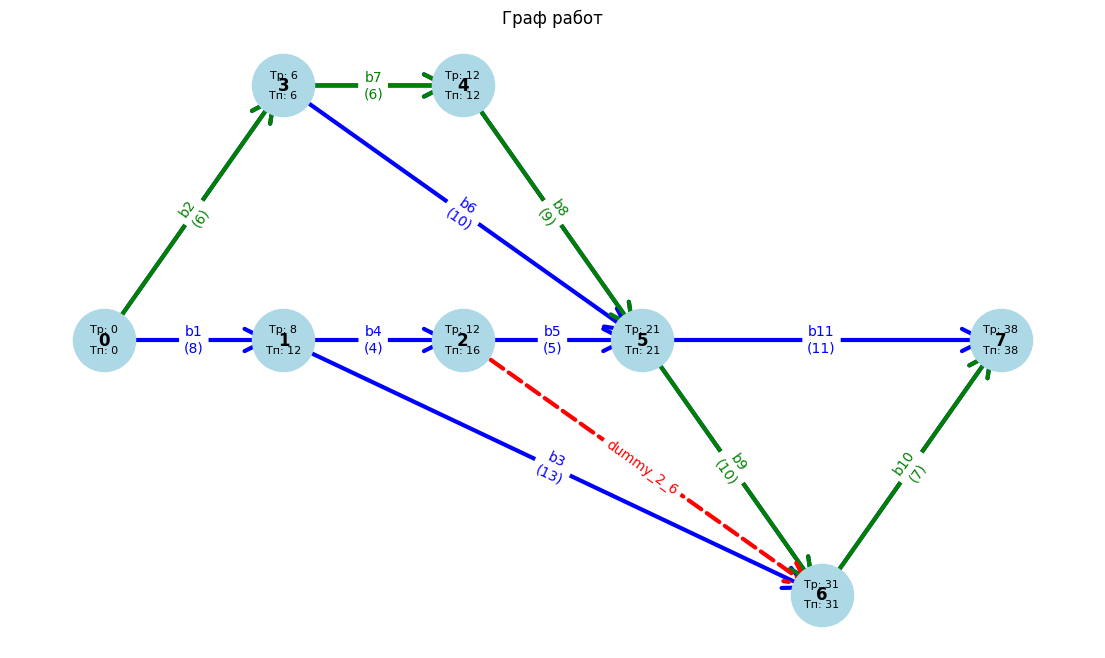

In [35]:
# Используем автоматические позиции
pos = calculate_positions(G)

plt.figure(figsize=(14, 8))

# Разделяем реальные и фиктивные работы
real_edges = [(u, v) for u, v, d in G.edges(data=True) if d['real']]
dummy_edges = [(u, v) for u, v, d in G.edges(data=True) if not d['real']]

# Выделяем критические работы
critical_real_edges = [edge for edge in real_edges if edge in critical_edges]

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Рисуем реальные работы (синие сплошные)
nx.draw_networkx_edges(G, pos, edgelist=real_edges, edge_color='blue',
                      width=3, arrowstyle='->', arrowsize=40)

# Рисуем критические работы (зеленые сплошные, толще)
nx.draw_networkx_edges(G, pos, edgelist=critical_real_edges, edge_color='green',
                      width=3, arrowstyle='->', arrowsize=40)

# Рисуем фиктивные работы (красные пунктирные)
nx.draw_networkx_edges(G, pos, edgelist=dummy_edges, edge_color='red',
                      width=3, style='dashed', arrowstyle='->', arrowsize=40)

# Подписи для реальных работ
real_labels = {(u, v): f"{d['task']}\n({d['duration']})" for u, v, d in G.edges(data=True) if d['real']}
nx.draw_networkx_edge_labels(G, pos, edge_labels=real_labels, font_color='blue')

# Подписи для критических работ (зеленые)
critical_labels = {(u, v): f"{G.edges[u, v]['task']}\n({G.edges[u, v]['duration']})" for u, v in critical_real_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=critical_labels, font_color='green')

# Подписи для фиктивных работ
dummy_labels = {(u, v): d['task'] for u, v, d in G.edges(data=True) if not d['real']}
nx.draw_networkx_edge_labels(G, pos, edge_labels=dummy_labels, font_color='red')

# Добавление меток для ранних и поздних сроков
early_labels = {node: f"Tр: {early_times[node]}" for node in G.nodes}
late_labels = {node: f"Tп: {late_times[node]}" for node in G.nodes}

# Позиции для меток
early_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
late_pos = {node: (x, y - 0.02) for node, (x, y) in pos.items()}

# Рисуем метки для ранних сроков
nx.draw_networkx_labels(G, early_pos, labels=early_labels, font_size=8)

# Рисуем метки для поздних сроков
nx.draw_networkx_labels(G, late_pos, labels=late_labels, font_size=8)
plt.title("Граф работ")
plt.axis('off')
plt.show()

# Вывод таблиц

In [36]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.colheader_justify', 'left')

print("\nРанние сроки наступления событий:")
pretty_render_table(early_df)

print("\nПоздние сроки наступления событий:")
pretty_render_table(late_df)

print("\nРезервы времени событий:")
pretty_render_table(reserves_df)

print("\nСводная таблица параметров событий:")
pretty_render_table(summary_df)

print("\nПараметры всех работ:")
pretty_render_table(works_df)

# Вывод информации о некритических дугах
if not chains_df.empty:
    if 'critical_path' in locals():
        print("Критический путь:", " - ".join(map(str, critical_path)))
    pretty_render_table(chains_df)
else:
    print("\nНекритические дуги не найдены")


Ранние сроки наступления событий:


,Этап,Tр,Пути достижения
0,0,0,Начальное
1,1,8,0 - 1 (8 дн.) = 0 + 8
2,2,12,1 - 2 (4 дн.) = 8 + 4
3,3,6,0 - 3 (6 дн.) = 0 + 6
4,4,12,3 - 4 (6 дн.) = 6 + 6
5,5,21,2 - 5 (5 дн.) = 12 + 53 - 5 (10 дн.) = 6 + 104 - 5 (9 дн.) = 12 + 9
6,6,31,1 - 6 (13 дн.) = 8 + 135 - 6 (10 дн.) = 21 + 102 - 6 (0 дн.) = 12 + 0
7,7,38,6 - 7 (7 дн.) = 31 + 75 - 7 (11 дн.) = 21 + 11



Поздние сроки наступления событий:


,Этап,Tп,Расчет
0,7,38,Tп(7) = Tкр= 38
1,6,31,min:Tп(7) - t67 = 38 - 7
2,5,21,min:Tп(6) - t56 = 31 - 10Tп(7) - t57 = 38 - 11
3,4,12,min:Tп(5) - t45 = 21 - 9
4,3,6,min:Tп(5) - t35 = 21 - 10Tп(4) - t34 = 12 - 6
5,2,16,min:Tп(5) - t25 = 21 - 5Tп(6) - t26 = 31 - 0
6,1,12,min:Tп(6) - t16 = 31 - 13Tп(2) - t12 = 16 - 4
7,0,0,min:Tп(1) - t01 = 12 - 8Tп(3) - t03 = 6 - 6



Резервы времени событий:


,Этап,R(i),Расчет
0,0,0,0 - 0
1,1,4,12 - 8
2,2,4,16 - 12
3,3,0,6 - 6
4,4,0,12 - 12
5,5,0,21 - 21
6,6,0,31 - 31
7,7,0,38 - 38



Сводная таблица параметров событий:


,Этап,Tр,Tп,R(i)
0,0,0,0,0
1,1,8,12,4
2,2,12,16,4
3,3,6,6,0
4,4,12,12,0
5,5,21,21,0
6,6,31,31,0
7,7,38,38,0



Параметры всех работ:


,Работа,Тип работы,Продолжительность,Нач. (S_p),Кон. (E_n),Полн. рез.,Незав. рез.
0,b1,Реальная,8,0,12,4,0
1,b2,Реальная,6,0,6,0,0
2,b3,Реальная,13,8,31,10,6
3,b4,Реальная,4,8,16,4,-4
4,b5,Реальная,5,12,21,4,0
5,b6,Реальная,10,6,21,5,5
6,b7,Реальная,6,6,12,0,0
7,b8,Реальная,9,12,21,0,0
8,b9,Реальная,10,21,31,0,0
9,b10,Реальная,7,31,38,0,0


Критический путь: 0 - 3 - 4 - 5 - 6 - 7


,Дуга,a,b,R(b),N(b),Работы
0,(0 - 5),21,17,4,0.810,b1+b4+b5
1,(0 - 6),31,21,10,0.677,b1+b3
2,(0 - 6),31,12,19,0.387,b1+b4
3,(0 - 7),38,28,10,0.737,b1+b4+b5+b11
4,(3 - 5),15,10,5,0.667,b6
5,(3 - 7),32,21,11,0.656,b6+b11
6,(5 - 7),17,11,6,0.647,b11
